# R Exercises - part 5
- Name: Alberto Coppi
- Student ID: 2053063
- E-mail: <alberto.coppi@studenti.unipd.it>

## Import useful libraries

In [6]:
library(ggplot2)
library(gridExtra)

## Ex1 - Radioactive source

In [7]:
Dt  <- 10
obs <- c(4, 1, 3, 1, 3)

### a)
Assuming a flat prior the posterior of a Poisson process is the Gamma distribution $Gamma(\mu|\alpha, \lambda)$ with $\alpha=(\sum_{i=1}^n x_i) +1$ and $\lambda=n$ where ${x_i}$ is the set of observations and $n$ its magnitude.

In [52]:
u_alpha  <- sum(obs) + 1
u_lambda <- length(obs)

u_posterior <- function(mu) {dgamma(mu, shape=u_alpha, rate=u_lambda)}

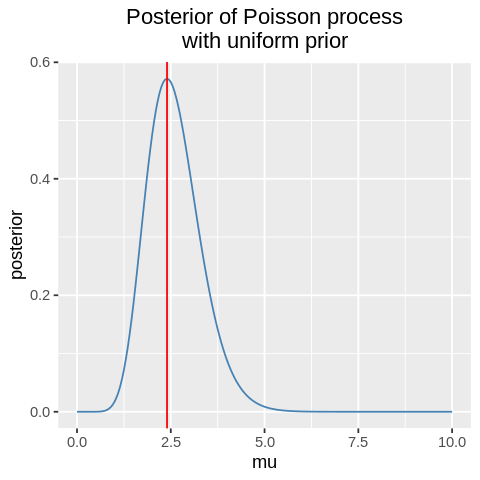

In [53]:
plot_pdf <- function(pdf, title) {
    mus <- seq(0, 10, length.out=201)

    options(repr.plot.width=4, repr.plot.height=4)
    plt <- ggplot(data.frame(mu=mus, posterior=pdf(mus)), aes(x=mu, y=posterior)) +
           geom_path(color='steelblue') +
           geom_vline(aes(xintercept=mu[which.max(posterior)]), color='red') +
           labs(title=title) +
           theme(plot.title=element_text(hjust=0.5))
    show(plt)
}

plot_pdf(u_posterior, 'Posterior of Poisson process\nwith uniform prior')

Now we calculate analitically and numerically the mean, median and variance. As the Gamma distribution has no analitical form to calculate the median, we calculate it using `qgamma`

In [55]:
u_mean.th   <- u_alpha/u_lambda
u_median.th <- qgamma(0.5, u_alpha, u_lambda)                              # alpha*(1-1/(9*alpha))^3
u_var.th    <- u_alpha/(u_lambda^2)

n_momentum <- function(n, pdf) {
    integrate(function(x) {x^n*pdf(x)}, lower=0, upper=Inf)[[1]]
}   

# experimental mean
u_mean.exp   <- n_momentum(1, u_posterior)

# experimental median
x <- 0
while(TRUE) {
    z <- integrate(u_posterior, lower=0, upper=x)[[1]]
    if(z>=0.5) break
    else x <- x+precision
}
u_median.exp <- x

# experimental variance
u_var.exp    <- n_momentum(2, u_posterior) - u_mean.exp^2

df <- data.frame(mean=c(u_mean.th, u_mean.exp), 
                 median=c(u_median.th, u_median.exp), 
                 variance=c(u_var.th, u_var.exp))
rownames(df) <- c('Analy.', 'Num.')
df

,mean,median,variance
,<dbl>,<dbl>,<dbl>
Analy.,2.6,2.533646,0.52
Num.,2.6,2.533700,0.52


### b)
Assuming a Jeffrey's prior the posterior of a Poisson process is the Gamma distribution $Gamma(\mu|\alpha, \lambda)$ with $\alpha=(\sum_{i=1}^n x_i) +\frac{1}{2}$ and $\lambda=n$ where ${x_i}$ is the set of observations and $n$ its magnitude.

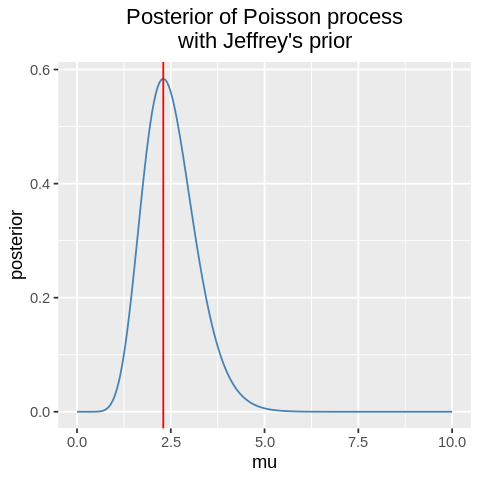

In [56]:
j_alpha  <- sum(obs) + 1/2
j_lambda <- length(obs)

j_posterior <- function(mu) {dgamma(mu, shape=j_alpha, rate=j_lambda)}

plot_pdf(j_posterior, "Posterior of Poisson process\nwith Jeffrey's prior")

In [57]:
j_mean.th   <- j_alpha/j_lambda
j_median.th <- qgamma(0.5, j_alpha, j_lambda)                              # alpha*(1-1/(9*alpha))^3
j_var.th    <- j_alpha/(j_lambda^2)

# experimental mean
j_mean.exp   <- n_momentum(1, j_posterior)

# experimental median
x <- 0
while(TRUE) {
    z <- integrate(j_posterior, lower=0, upper=x)[[1]]
    if(z>=0.5) break
    else x <- x+precision
}
j_median.exp <- x

# experimental variance
j_var.exp    <- n_momentum(2, j_posterior) - j_mean.exp^2

df <- data.frame(mean=c(j_mean.th, j_mean.exp), 
                 median=c(j_median.th, j_median.exp), 
                 variance=c(j_var.th, j_var.exp))
rownames(df) <- c('Analy.', 'Num.')
df

,mean,median,variance
,<dbl>,<dbl>,<dbl>
Analy.,2.5,2.433659,0.5
Num.,2.5,2.433700,0.5


### c)

In [62]:

confidence_interval <- function(mean, dist, ..., cl=0.95, precision=10^-4) {
    a <- mean
    b <- mean
    while (TRUE) {
        z <- integrate(dist, lower=a, upper=mean, ...)[[1]] +
             integrate(dist, lower=mean, upper=b, ...)[[1]]
        if(z > cl) break
        else if(a-precision >= 0) {
            if(a-precision >= 0) a <- a-precision
            b <- b+precision  
        }
        else b <- b+precision 
    }
    return(c(a, b))
}

In [78]:
cl=0.95

ci.unif <- confidence_interval(u_mean.th, u_posterior, cl=cl)
ci.jeff <- confidence_interval(j_mean.th, j_posterior, cl=cl)

ci.unif.norm <- c(qnorm( (1-cl)/2, mean=u_mean.th, sd=sqrt(u_var.th) ), 
                  qnorm( (1+cl)/2, mean=u_mean.th, sd=sqrt(u_var.th) ))
ci.jeff.norm <- c(qnorm( (1-cl)/2, mean=j_mean.th, sd=sqrt(j_var.th) ), 
                  qnorm( (1+cl)/2, mean=j_mean.th, sd=sqrt(j_var.th) ))


cat(sprintf("Posterior with uniform prior:\n\tMean\t\t: %.2f\n\t%i%% C.I.\t: %.4f - %.4f\n\tnorm approx.\t: %.4f - %.4f", 
    u_mean.th, cl*100, ci.unif[[1]], ci.unif[[2]], ci.unif.norm[[1]], ci.unif.norm[[2]]), '\n')
cat(sprintf("Posterior with Jeffrey's prior:\n\tMean\t\t: %.2f\n\t%i%% C.I.\t: %.4f - %.4f\n\tnorm approx.\t: %.4f - %.4f",
    j_mean.th, cl*100, ci.jeff[[1]], ci.jeff[[2]], ci.jeff.norm[[1]], ci.jeff.norm[[2]]), '\n')

Posterior with uniform prior:
	Mean		: 2.60
	95% C.I.	: 1.2146 - 3.9854
	norm approx.	: 1.1866 - 4.0134 
Posterior with Jeffrey's prior:
	Mean		: 2.50
	95% C.I.	: 1.1425 - 3.8575
	norm approx.	: 1.1141 - 3.8859 


## Ex2 - Lighthouse problem

In [65]:
?qnorm

Normal                  package:stats                  R Documentation

_T_h_e _N_o_r_m_a_l _D_i_s_t_r_i_b_u_t_i_o_n

_D_e_s_c_r_i_p_t_i_o_n:

     Density, distribution function, quantile function and random
     generation for the normal distribution with mean equal to ‘mean’
     and standard deviation equal to ‘sd’.

_U_s_a_g_e:

     dnorm(x, mean = 0, sd = 1, log = FALSE)
     pnorm(q, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
     qnorm(p, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)
     rnorm(n, mean = 0, sd = 1)
     
_A_r_g_u_m_e_n_t_s:

    x, q: vector of quantiles.

       p: vector of probabilities.

       n: number of observations. If ‘length(n) > 1’, the length is
          taken to be the number required.

    mean: vector of means.

      sd: vector of standard deviations.

log, log.p: logical; if TRUE, probabilities p are given as log(p).

lower.tail: logical; if TRUE (default), probabilities are P[X <=